In [35]:
import numpy as np
from matplotlib import pyplot as plt

In [66]:

def ppi_k(b,p,q, n=100, k=1000):
    
    y = np.random.binomial(1,b,size=(n,k))
    f = np.random.binomial(1, y*p + (1-y) * (1-q) )

    sum_y_l  = (y).sum(axis=0)
    sum_f_l  = (f).sum(axis=0)
    sum_yf_l = (y * f).sum(axis=0)

    mean_y_l = sum_y_l / n
    mean_f_l = sum_f_l / n
    
    mean_f_u = b*p + (1-b) * (1-q)
    var_f_u = mean_f_u * (1-mean_f_u)

    # Covariance on labeled set: matches np.cov(yl, fl)[0,1] default ddof=1
    cov_yf_l = (sum_yf_l - n * mean_y_l * mean_f_l) / (n - 1)
    denom = var_f_u

    lam = np.where(np.abs(denom) > 0.0, cov_yf_l / denom, 0.0)
    est = mean_y_l + lam * (mean_f_u - mean_f_l)
    return est


def bound(sd,step,weight,beta):
    return weight * (sd + 2*beta / np.sqrt(step)) / step 

    
    
    
def adaptive_strat_k(b,p,q,n=100,k=1024,beta="standard"):
    #beta = 0.1
    if beta == "standard":
        beta = np.sqrt(4.5*np.log(n))
    
    #Approach: Prefill r, then simply move the index 
    #For this, we need to invert the data generating process... 
    
    #probability of predicted labels 0,1 
    w0 = b * (1-p) + (1-b) * q
    w1 = 1 - w0
    
    #Correct label conditional on labels 0,1 
    p0 =  (1-p) * b / w0
    p1 = p * b / w1 
    
    starget0 = w0 * np.sqrt(p0*(1-p0))
    starget1 = w1 * np.sqrt(p1*(1-p1))
    
    r0 = np.random.binomial(1,p0,size=(n,k))
    r1 = np.random.binomial(1,p1,size=(n,k))
    
    
    n0 = np.zeros(k, dtype=int) + 2
    n1 = np.zeros(k, dtype=int) + 2 #Initial two draws per arm
    
    s0 = r0[:2].sum(0)
    s1 = r1[:2].sum(0)  #Initial sums of inputs. These are also the sum of squares because everything is binary! 
    
    idx = np.arange(k)
    
    for _ in range(max(n - 5, 0)):
        std0 = np.sqrt((s0 - (s0)**2 / n0) / (n0-1))
        std1 = np.sqrt((s1 - (s1)**2 / n1) / (n1-1))
        
        
        b0 = bound(std0, n0, w0, beta)
        b1 = bound(std1, n1, w1, beta)

        choose0 = b0 >= b1
        choose1 = ~choose0

        if choose0.any():        
            i0 = idx[choose0]
            s0[i0] += r0[n0[i0],i0]
            n0[i0] += 1

        if choose1.any():
            i1 = idx[choose1]
            s1[i1] += r1[n1[i1],i1]
            n1[i1] += 1
     
    m0 = s0 / n0
    m1 = s1 / n1  
    #print(np.sqrt(p0*(1-p0)),w0,np.sqrt(p1*(1-p1)),w1)
    print("optimal_a", starget0/(starget0 + starget1), starget1/(starget0+starget1))
    #print("optimal",np.mean(w0 * std0) / (np.mean(w0*std0) + np.mean(w1 * std1)), 
    #      np.mean(w1 * std1) / (np.mean(w0*std0) + np.mean(w1 * std1))  )
    print("empirical",np.sum(n0)/np.sum(n0+n1),np.sum(n1)/np.sum(n0+n1))
    return w0 * m0 + w1 * m1


def get_conditional_stds(b=0.9,p=0.9,q=0.9):
    pf1 = b * p + (1-b) * (1-q)
    
    p0 = (1-p)*b/(1-pf1)
    p1 = p * b / pf1 
    return np.sqrt(p0*(1-p0)),np.sqrt(p1*(1-p1))

In [71]:
def scaleplot(ns,k=100,b=0.9,p=0.9,q=0.9,ppi=True,strat=True):

    print(get_conditional_stds(b,p,q))
    y = np.random.binomial(1,b,size=(1000000))
    f = np.random.binomial(1, y*p + (1-y) * (1-q) )
    
    def mse(results):
        return np.mean((np.array(results) - b)**2)
    
    def var(results):
        return np.var(results)

    def bias(results):
        return np.mean(np.array(results) - b)
    
    w0 = b * (1-p) + (1-b) * q
    w1 = 1 - w0
    
    if ppi:
        ppi_results = {key: ppi_k(b,p,q,n=key,k=k) for key in ns}
        mse_ppi = [mse(ppi_results[n])*n for n in ns ]
        pred_ppi = np.var(y) * (1-np.corrcoef(y,f)[0,1]**2)
        pred_ppi_gpt = w0 * np.var(y[f==0]) + w1*np.var(y[f==1])
        
    if strat:
        strat_results = {key: adaptive_strat_k(b,p,q,n=key,k=k) for key in ns}
        strat_results_b = {key: adaptive_strat_k(b,p,q,n=key,k=k,beta=0.5) for key in ns}
        
        mse_strat = [mse(strat_results[n])*n for n in ns ]
        mse_strat_b = [mse(strat_results_b[n])*n for n in ns ]
        
        pred_strat = (w0 * np.std(y[f==0]) + w1*np.std(y[f==1]))**2
    
    #plt.plot(ns,bias_ppi,linestyle="--",color="blue")
    #plt.plot(ns,bias_strat,linestyle="--",color="orange")
    #plt.plot(ns,var_ppi,linestyle="--",color="blue")
    #plt.plot(ns,var_strat,linestyle="--",color="orange")
    
    

    
    pred_naive = np.var(y)
    
    if ppi:
        plt.plot(ns,[pred_ppi for n in ns],color="blue",linestyle="--",alpha=0.5)
        plt.scatter(ns,[pred_ppi_gpt for n in ns],color="blue",linestyle="--",alpha=0.5)
        plt.plot(ns,mse_ppi,color="blue")
    if strat:
        plt.plot(ns,[pred_strat for n in ns],color="orange",linestyle="--",alpha=0.5)
        plt.plot(ns,mse_strat,color="orange")
        plt.plot(ns,mse_strat_b,color="darkorange")
    plt.plot(ns,[pred_naive for n in ns],color="black",linestyle="--")
   
   
    
    
    #plt.legend(["ppi","stratified"])
    
    
    plt.show()
    
    
#Check separate scaling
#PPI: Linear in k and n 
#Stratification: Linear-ish in k 

In [72]:
ns = [100,310,1000,3100,10000,31000]

(0.5, 0.10975609756097567)
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.29471414141414143 0.7052858585858586
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.30138187702265373 0.6986181229773463
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.3165057057057057 0.6834942942942943
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.33813714101323006 0.6618628589867699
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.3658777077707771 0.6341222922292229
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.3952979225136295 0.6047020774863705
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.43548383838383836 0.5645161616161616
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.45238576051779933 0.5476142394822007
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.4559185185185185 0.5440814814814815
optimal_a 0.4999999999999998 0.5000000000000001
empirical 0.4669017424975799 0.5330982575024201
optimal_

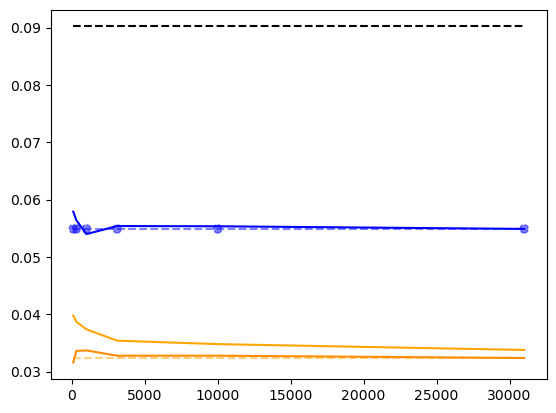

In [74]:
scaleplot(ns,k=10000,b=0.9,p=0.9,q=0.9)

(0.0, 0.4714045207910317)
optimal_a 0.0 1.0
empirical 0.27493737373737376 0.7250626262626263
optimal_a 0.0 1.0
empirical 0.25284498381877024 0.7471550161812298
optimal_a 0.0 1.0
empirical 0.2227732732732733 0.7772267267267268
optimal_a 0.0 1.0
empirical 0.18905546950629235 0.8109445304937076
optimal_a 0.0 1.0
empirical 0.15247098709870988 0.8475290129012901
optimal_a 0.0 1.0
empirical 0.11906611181005838 0.8809338881899416
optimal_a 0.0 1.0
empirical 0.14112727272727274 0.8588727272727272
optimal_a 0.0 1.0
empirical 0.10237087378640777 0.8976291262135923
optimal_a 0.0 1.0
empirical 0.07265095095095095 0.927349049049049
optimal_a 0.0 1.0
empirical 0.05138835108099387 0.9486116489190062
optimal_a 0.0 1.0
empirical 0.035504300430043004 0.964495699569957
optimal_a 0.0 1.0
empirical 0.024665015000483886 0.9753349849995161


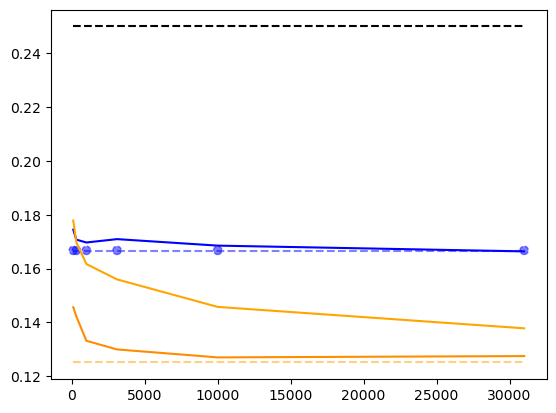

In [75]:
scaleplot(ns,k=10000,b=0.5,p=1,q=0.5)

(0.3, 0.3)
optimal_a 0.5 0.5
empirical 0.5005767676767677 0.4994232323232323
optimal_a 0.5 0.5
empirical 0.5000588996763754 0.4999411003236246
optimal_a 0.5 0.5
empirical 0.5000513513513514 0.49994864864864863
optimal_a 0.5 0.5
empirical 0.499929590190384 0.500070409809616
optimal_a 0.5 0.5
empirical 0.5000148614861486 0.4999851385138514
optimal_a 0.5 0.5
empirical 0.4999968353817865 0.5000031646182135
optimal_a 0.5 0.5
empirical 0.4991090909090909 0.500890909090909
optimal_a 0.5 0.5
empirical 0.5000087378640776 0.4999912621359223
optimal_a 0.5 0.5
empirical 0.49992062062062065 0.5000793793793794
optimal_a 0.5 0.5
empirical 0.5000130041949016 0.4999869958050984
optimal_a 0.5 0.5
empirical 0.5000347334733474 0.4999652665266527
optimal_a 0.5 0.5
empirical 0.4999707506693764 0.5000292493306235


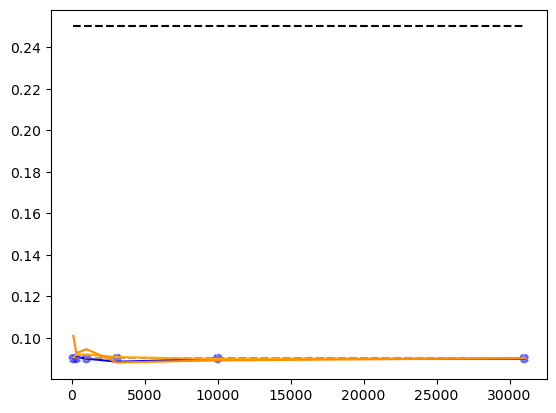

In [76]:
scaleplot(ns,k=10000,b=0.5,p=0.9,q=0.9)

(0.49999999999999994, 0.010099979596000274)
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.08057272727272727 0.9194272727272728
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.08064660194174757 0.9193533980582524
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.085604004004004 0.914395995995996
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.09483972249112617 0.9051602775088738
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.11080664066406641 0.8891933593359336
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.13440386786670538 0.8655961321332947
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.12877777777777777 0.8712222222222222
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.16982653721682847 0.8301734627831715
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.23307687687687687 0.7669231231231232
optimal_a 0.5000000000000137 0.49999999999998634
empirical 0.3090806389157793

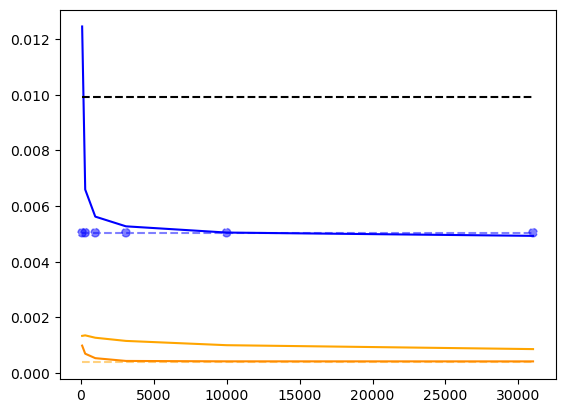

In [77]:
scaleplot(ns,k=10000,b=0.99,p=0.99,q=0.99)

(0.3, 0.3)
optimal_a 0.5 0.5
empirical 0.5006727272727273 0.49932727272727273
optimal_a 0.5 0.5
empirical 0.500089644012945 0.499910355987055
optimal_a 0.5 0.5
empirical 0.5000528528528528 0.49994714714714716
optimal_a 0.5 0.5
empirical 0.50001900613101 0.49998099386899
optimal_a 0.5 0.5
empirical 0.5000553255325533 0.4999446744674467
optimal_a 0.5 0.5
empirical 0.5000078034775315 0.49999219652246846
optimal_a 0.5 0.5
empirical 0.5009292929292929 0.49907070707070705
optimal_a 0.5 0.5
empirical 0.4999990291262136 0.5000009708737864
optimal_a 0.5 0.5
empirical 0.500212012012012 0.499787987987988
optimal_a 0.5 0.5
empirical 0.5000334624072281 0.4999665375927719
optimal_a 0.5 0.5
empirical 0.5000149514951495 0.4999850485048505
optimal_a 0.5 0.5
empirical 0.499999264492403 0.500000735507597


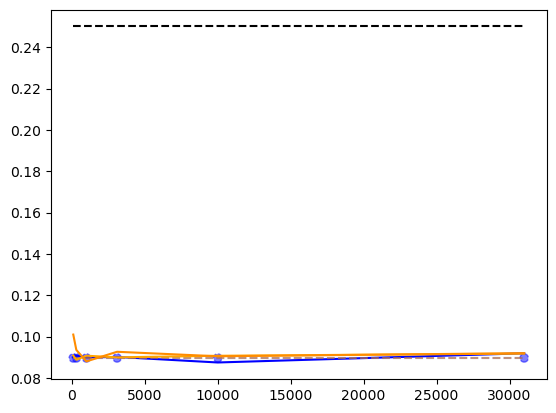

In [78]:
scaleplot(ns,k=10000,b=0.5,p=0.9,q=0.9)

(0.48650425541051984, 0.0)
optimal_a 1.0 0.0
empirical 0.565629292929293 0.4343707070707071
optimal_a 1.0 0.0
empirical 0.5949987055016182 0.4050012944983819
optimal_a 1.0 0.0
empirical 0.6332952952952953 0.36670470470470473
optimal_a 1.0 0.0
empirical 0.6797763149403033 0.32022368505969667
optimal_a 1.0 0.0
empirical 0.7341623462346235 0.26583765376537655
optimal_a 1.0 0.0
empirical 0.7872347817671538 0.21276521823284622
optimal_a 1.0 0.0
empirical 0.7567252525252526 0.24327474747474748
optimal_a 1.0 0.0
empirical 0.8160278317152103 0.18397216828478966
optimal_a 1.0 0.0
empirical 0.8663526526526526 0.13364734734734735
optimal_a 1.0 0.0
empirical 0.9040344949983866 0.09596550500161342
optimal_a 1.0 0.0
empirical 0.9329738773877387 0.06702612261226122
optimal_a 1.0 0.0
empirical 0.9531062905255008 0.046893709474499175


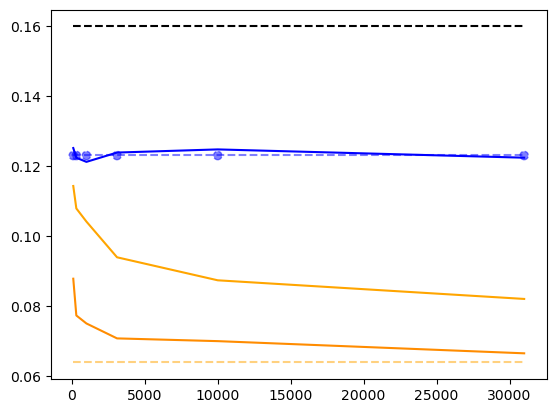

In [79]:
scaleplot(ns,k=10000,b=0.8,p=0.6,q=1)

(0.5, 0.0010009999980174638)
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.018014714714714716 0.9819852852852853
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.018918812520167794 0.9810811874798322
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.020984068406840684 0.9790159315931594
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.024681538114132713 0.9753184618858672
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.039781881881881885 0.9602181181181181
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.05857976766698935 0.9414202323330106
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.09194492449244925 0.9080550755075507
optimal_a 0.5000000000084888 0.4999999999915113
empirical 0.1423781025194361 0.8576218974805639


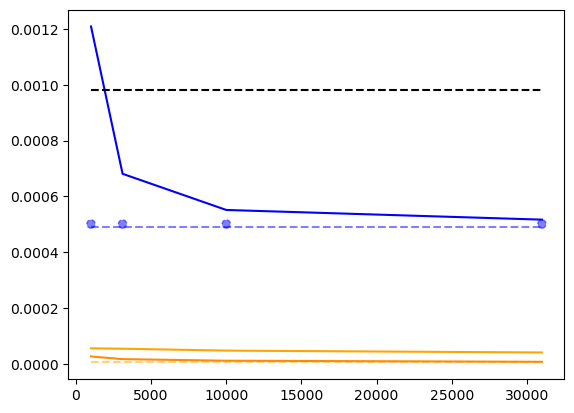

In [81]:
scaleplot([1000,3100,10000,31000],k=10000,b=0.999,p=0.999,q=0.999)

In [ ]:
scaleplot([100,310,1000,10000,100000],k=100000,b=0.8,p=0.6,q=1,ppi=False)

(0.48650425541051984, 0.0)
optimal_a 1.0 0.0
optimal 1.0 0.0
empirical 0.5656288888888888 0.4343711111111111
optimal_a 1.0 0.0
optimal 1.0 0.0
empirical 0.5949947572815534 0.4050052427184466
optimal_a 1.0 0.0
optimal 1.0 0.0
empirical 0.6333109009009009 0.3666890990990991
optimal_a 1.0 0.0
optimal 1.0 0.0
empirical 0.7341610361036104 0.2658389638963896


In [ ]:
#Hypothesis: Bound is too conservative?

In [ ]:
%prun ppi_k(y,f,k=10000)

(0.27638539919628335, 0.03346370304170169)
0.2701490966420633 0.03345415145210746
0.0736 0.0021242645786248007
0.1499766281904394 0.005162416288222859
0.22899364190795826 0.009266921370569774
0.26057145317913427 0.01605774244589575
0.2678250879295009 0.024630010490377732


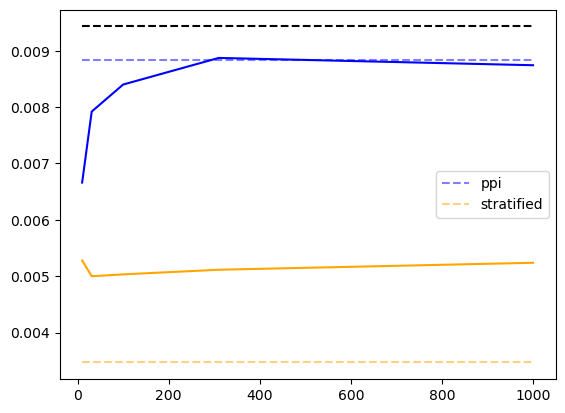

In [17]:
scaleplot(ns,k=10000,b=0.99,p=0.9,q=0.9)

(0.49999999999999994, 0.010099979596000274)
0.4999262775973509 0.013168291981600746
0.2513 0.00044721359549995795
0.23667227723096212 0.0008498365855987974
0.4610297635297718 0.001555907280424476
0.48942887127568235 0.002763439307988343
0.4969236679110038 0.004930964128377296


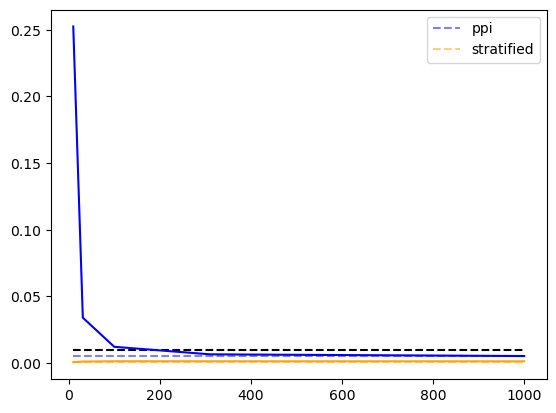

In [18]:
scaleplot(ns,k=10000,b=0.99,p=0.99,q=0.99)

(0.0, 0.014210510280216773)
0.0 0.014905764473982652
0.0 0.0005688896468290542
0.0 0.0011331154474650631
0.0 0.002279309175595938
0.0 0.00381354316284748
0.0 0.0062865889549181065


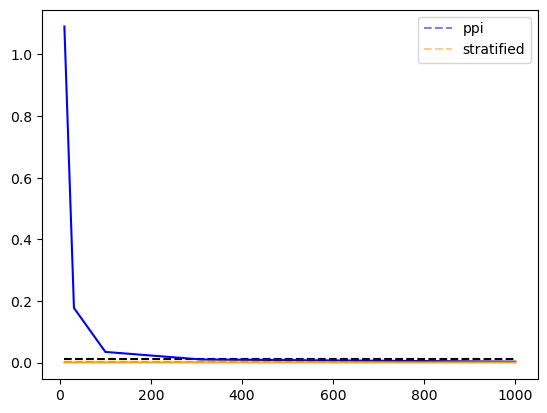

In [19]:
scaleplot(ns,k=10000,b=0.99,p=1,q=0.98)

(0.47218950602249304, 0.0)
0.47421698160170545 0.0
0.2229 0.0
0.317113821136127 0.0
0.4409285531920884 0.0
0.4654894802080451 0.0
0.4718577303515574 0.0


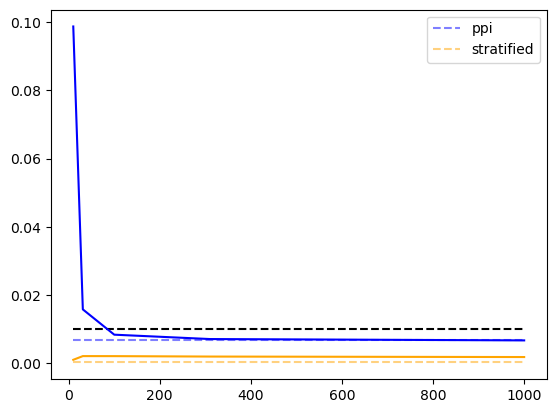

In [20]:
scaleplot(ns,k=10000,b=0.99,p=0.98,q=1)

(0.4714045207910317, 0.0)
0.47238367633059775 0.0
0.35988727033164863 0.0
0.45501056594725087 0.0
0.4681034275656728 0.0
0.4710199963296293 0.0
0.47196742469440967 0.0


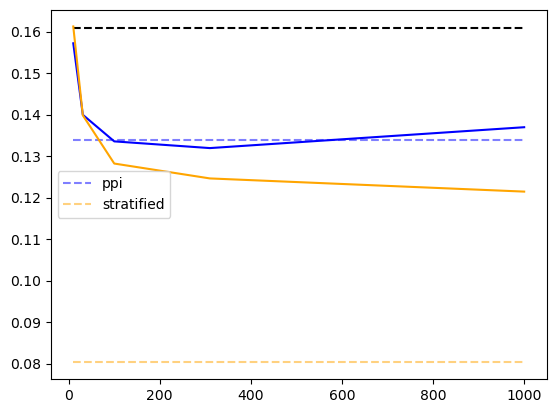

In [22]:
scaleplot(ns,k=10000,b=0.8,p=0.5,q=1)

(0.0, 0.3142696805273544)
0.0 0.3156012370134675
0.0 0.20580703252029062
0.0 0.2932956990663401
0.0 0.3109646279061691
0.0 0.31406533455365926
0.0 0.3152385684352758


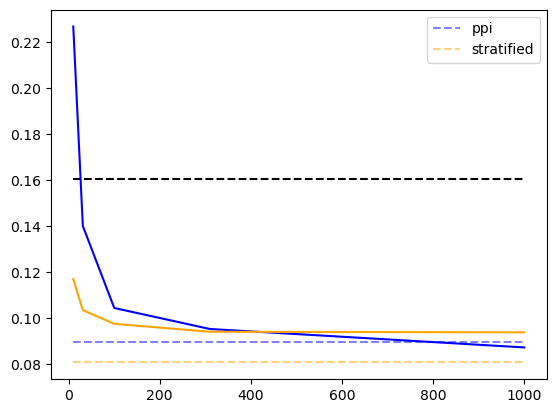

In [23]:
scaleplot(ns,k=10000,b=0.8,p=1,q=0.5)

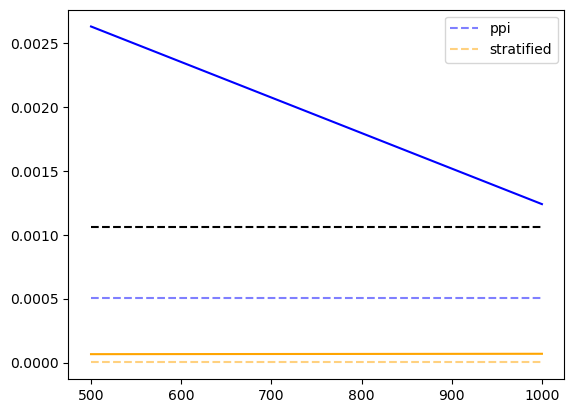

In [20]:
scaleplot([500,1000],k=10000,b=0.999,p=0.999,q=0.999)

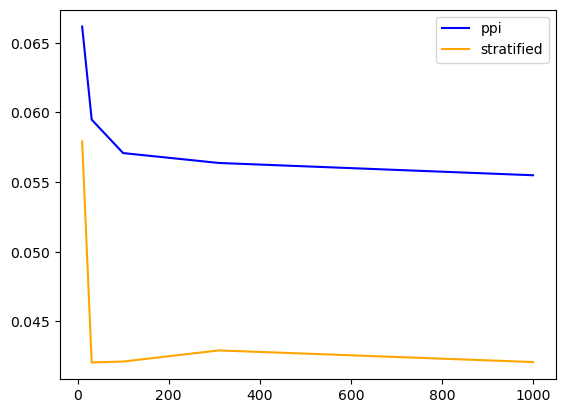

In [141]:
scaleplot(ns,k=10000,b=0.9,p=0.9,q=0.9)

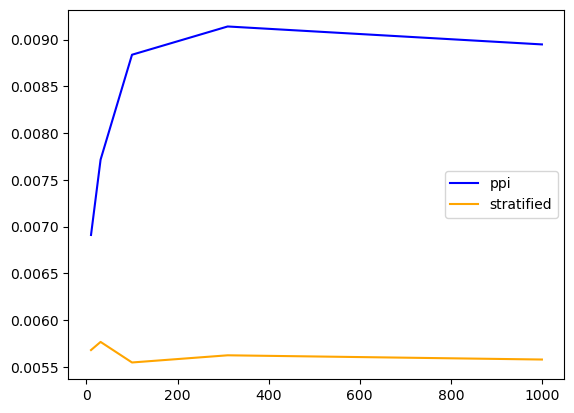

In [145]:
scaleplot(ns,k=10000,b=0.99,p=0.9,q=0.9)

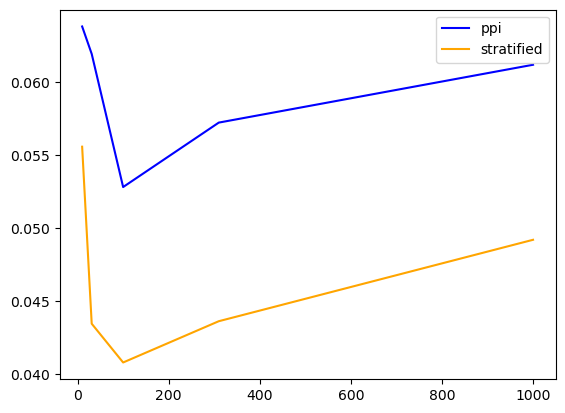

In [140]:
%prun scaleplot(ns,k=1000,b=0.9,p=0.9,q=0.9)

In [ ]:
#sanity check:

In [53]:
np.var(y) * (1-np.corrcoef(y,f)[0,1]**2)

0.05491889346890283

In [90]:
np.var(y)

0.09006871262118996

In [106]:
for n in ns:
    print(mse(ppi_results[n])*n , bias(ppi_results[n]))

0.06911240238201868 0.004070913126743343
0.0748652014272858 0.0005346347519852554
0.07443164372815175 0.0004934873921016108
0.07667872375629183 0.0001676810941211192


In [107]:
strat_results = {key: [adaptive_strat(key) for i in range(100)] for key in ns}

In [108]:
for n in ns:
    print(mse(strat_results[n])*n , bias(strat_results[n]))

0.035923309796178346 0.0027934457077449693
0.039827083765830995 -0.0004696739332554567
0.03151615353355091 -0.00015667168592429115
0.028293563320116108 0.0005414980311307482


In [ ]:
def ppi(y,f,n=100):
    mask = np.zeros_like(y,dtype=bool)
    subset = np.random.choice(np.arange(len(y)),size=n,replace=False)
    mask[subset] = 1 
    
    yl = y[mask]
    fl = f[mask]
    fr = f[~mask]
    
    lam = np.cov(yl,fl)[0,1] / ((1 + n / len(fr)) * np.var(fr))
    if np.isinf(lam):
        lam = 0.0
        
    #lam = 0.0 For lambda = 0, things seem to behave as expected...

    return lam * (np.mean(fr) - np.mean(fl)) + np.mean(yl)


def adaptive_strat(n=100, beta = 1 ):
    a0 = y[f==0]
    a1 = y[f==1]
    
    w0 = len(a0)/(len(a0) + len(a1))
    w1 = len(a1)/(len(a0) + len(a1))
    
    r0 = np.zeros(n)
    r1 = np.zeros(n)
    
    p0 = 0 
    p1 = 0
    
    for i in range(2):
        r0[p0] = np.random.choice(a0)
        r1[p1] = np.random.choice(a1)
        p0 += 1
        p1 += 1
        
    while p0+p1 < n-1:
        b0 = bound(np.std(r0[:p0]),p0, w0, beta)
        b1 = bound(np.std(r1[:p0]),p1, w1, beta)
        
        if b0 >= b1:
            r0[p0] = np.random.choice(a0)
            p0 += 1
            
        else:
            r1[p1] = np.random.choice(a1)
            p1+=1
    
    return w0 *  np.mean(r0[:p0]) + w1 * np.mean(r1[:p1])

In [76]:
a = np.empty(10)

In [78]:
a[0] = 0

In [2]:
def var_strat(x,y):
    p_total = len(x) + len(y)
    px = len(x) / p_total
    py = len(y) / p_total
    return  2*(px**2 * np.var(x) + py**2 * np.var(y))

In [3]:
def var_strat(x,y,w1=0.5,w2=0.5):
    # renormalize w1 and w2...
    w1n = w1 / (w1+w2)
    w2n = w2 / (w1+w2)
    p_total = len(x) + len(y)
    px = len(x) / p_total
    py = len(y) / p_total
    return  (px**2 * np.var(x) / w1n + py**2 * np.var(y) / w2n)

In [80]:
np.mean(a)

5e-324

/var/folders/ck/kgc5rjgn1s76_fwbdngtj5cm0002mx/T/ipykernel_6662/3947341209.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  lam = np.cov(yl,fl)[0,1] / ((1 + n / len(fr)) * np.var(fr))
/var/folders/ck/kgc5rjgn1s76_fwbdngtj5cm0002mx/T/ipykernel_6662/3947341209.py:10: RuntimeWarning: invalid value encountered in scalar divide
  lam = np.cov(yl,fl)[0,1] / ((1 + n / len(fr)) * np.var(fr))


In [50]:
ppi_results = [ppi() for i in range(1000)]

0.0007353249304906597

In [52]:
ppi()

0.8780116642616642

In [4]:
a = np.array([1,0,1,1,1,0,0,0]) #Proxy
b = np.array([0,1,1,1,1,0,0,0]) #Original

In [5]:
np.corrcoef(a,b)[0,1]

0.4999999999999999

In [6]:
np.var(b) * (1-np.corrcoef(a,b)[0,1]**2)

0.18750000000000003

In [7]:
np.var(a-b)

0.25

In [8]:
np.var(b[a==0]) 

0.1875

In [9]:
np.var(b[a==1]) 

0.1875

In [10]:
var_strat(b[a==0],b[a==1])

0.1875

In [11]:
# Symmetric stratified sampling matches ppi ++ 

In [12]:
a = np.array([1,1,1,0,1,1,1,0,0,0]) #Proxy
b = np.array([0,0,0,1,1,1,1,0,0,0]) #Original

In [13]:
np.corrcoef(a,b)[0,1]

0.25000000000000006

In [14]:
np.var(b) * (1-np.corrcoef(a,b)[0,1]**2)

0.22500000000000003

In [15]:
np.var(a-b)

0.36000000000000004

In [16]:
np.var(b[a==0]) 

0.1875

In [17]:
np.var(b[a==1]) 

0.25

In [18]:
var_strat(b[a==0],b[a==1],1,1)

0.24

In [21]:
var_strat(b[a==0],b[a==1],np.std(b[a==0]),np.std(b[a==1]))

0.23258330249197706

In [22]:
var_strat(b[a==0],b[a==1],len(b[a==0])*np.std(b[a==0]),len(b[a==1])*np.std(b[a==1]))

0.22392304845413263

In [ ]:
    
def substd(r1,n1):
    n, k = r1.shape
    m = n1.max()
    x = r1[:m].astype(float)          # only up to needed max length
    cs  = x.cumsum(0)
    cs2 = (x*x).cumsum(0)

    j = np.arange(k)
    i = n1 - 1
    s  = cs[i,  j]
    s2 = cs2[i, j]

    var = (s2 - s*s/n1) / (n1 - 1)
    std = np.sqrt(np.maximum(var, 0.0))
    return std

In [ ]:
def adaptive_strat_k(y,f,n=100,k=1024):
    
    beta = np.sqrt(4.5*np.log(n))
    
    # Prefill r 
    
    a0 = y[f == 0]
    a1 = y[f == 1]

    w0 = a0.size / (a0.size + a1.size)
    w1 = 1.0 - w0

    # r0/r1 mirror your original arrays, but vectorized over k
    r0 = np.full((k, n), np.nan, dtype=float)
    r1 = np.full((k, n), np.nan, dtype=float)

    p0 = np.zeros(k, dtype=int)
    p1 = np.zeros(k, dtype=int)

    # Warm start: for i in range(2): sample one from each stratum
    r0[:, 0] = np.random.choice(a0, size=k)
    r1[:, 0] = np.random.choice(a1, size=k)
    r0[:, 1] = np.random.choice(a0, size=k)
    r1[:, 1] = np.random.choice(a1, size=k)
    p0 += 2
    p1 += 2
    
    sum0 = r0[:, 0] + r0[:, 1]
    sum1 = r1[:, 0] + r1[:, 1]
    sumsq0 = r0[:, 0] * r0[:, 0] + r0[:, 1] * r0[:, 1]
    sumsq1 = r1[:, 0] * r1[:, 0] + r1[:, 1] * r1[:, 1]

    # Same stopping logic as: while p0+p1 < n-1
    # Start at 4 total draws; stop at (n-1) => add (n-5) draws.
    idx = np.arange(k)

    for _ in range(max(n - 5, 0)):
        mean0 = sum0 / p0
        mean1 = sum1 / p1

        var0 = (sumsq0 - (sum0 * sum0) / p0) / (p0 - 1)
        var1 = (sumsq1 - (sum1 * sum1) / p1) / (p1 - 1)

        std0 = np.sqrt(np.maximum(var0, 0.0))
        std1 = np.sqrt(np.maximum(var1, 0.0))
        
        std0 =  np.nanstd(r0[:,:_+5],axis=1)
        std1 = np.nanstd(r1[:,:_+5],axis=1)
        
        #print(np.mean(std0),np.mean(std0b))
        #print(np.mean(std1),np.mean(std1b))
        #std0 = np.nanstd(r0, axis=1)  # equivalent to np.std(r0[:p0]) per experiment
        #std1 = np.nanstd(r1, axis=1)  # equivalent to np.std(r1[:p1]) per experiment

        b0 = bound(std0, p0, w0, beta)
        b1 = bound(std1, p1, w1, beta)

        choose0 = b0 >= b1
        choose1 = ~choose0

        if choose0.any():
            i0 = idx[choose0]
            r0[i0, p0[i0]] = np.random.choice(a0, size=i0.size)
            p0[i0] += 1

        if choose1.any():
            i1 = idx[choose1]
            r1[i1, p1[i1]] = np.random.choice(a1, size=i1.size)
            p1[i1] += 1
    #print(np.mean(std0),np.mean(std1),np.mean(np.nanstd(r0,axis=1)),np.mean(np.nanstd(r1,axis=1)))
    print(np.mean(std0),np.mean(std1))
    return w0 * np.nanmean(r0, axis=1) + w1 * np.nanmean(r1, axis=1)